In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/CS544 Project/notebooks

/content/drive/Shareddrives/CS544 Project/notebooks


In [ ]:
%%capture
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import math
import torch
import transformers as ppb
import warnings
import re
warnings.filterwarnings('ignore')

In [ ]:
dfs = pd.read_excel("nlp_path_data.xlsx")
#dfs = dfs.rename(columns={'10000194': 'numbers', 'S19-09556': 'code', "Invasive carcinoma of no special type (invasive ductal carcinoma, not otherwise ...": "descriptions"})

In [ ]:
dfs.head()

In [ ]:
np.unique(dfs["Code"])
print(len(np.unique(dfs["Code"])))

117


In [ ]:
dfs["Code"].value_counts()

8500    1563
8140     827
8550     796
8070     325
8120     294
        ... 
9043       1
9231       1
8046       1
9680       1
8806       1
Name: Code, Length: 117, dtype: int64

In [ ]:
# Codes we actually want to use:
df_grouped = dfs.groupby(["Code"]).count().reset_index()
codes = df_grouped[df_grouped["Dx"] > 10]["Code"].values
codes

array([8000, 8010, 8020, 8050, 8070, 8071, 8072, 8085, 8120, 8130, 8140,
       8144, 8150, 8170, 8230, 8240, 8250, 8252, 8260, 8310, 8312, 8317,
       8335, 8340, 8380, 8441, 8442, 8461, 8480, 8500, 8510, 8520, 8522,
       8550, 8575, 8720, 8721, 8742, 8743, 8744, 8745, 8802, 8850, 8858,
       8890, 8936, 9061, 9070, 9071])

In [1]:
dfs = dfs[dfs["Code"].isin(codes)]


NameError: ignored

In [ ]:
dfs["Code"].value_counts()

8500    1563
8140     827
8550     796
8070     325
8120     294
8312     237
8050     213
8743     204
8441     184
8380     181
8520     174
8000     173
8480     118
8130     115
8720      96
8010      85
8522      71
8936      70
8260      66
8150      58
8721      47
8240      47
8071      46
8744      44
8340      38
8850      34
8742      31
8170      27
8745      26
8072      25
8317      24
8461      20
8230      19
9061      19
8802      18
8575      17
8858      16
8250      15
8020      15
8252      15
8890      14
8442      14
9070      13
8085      13
8335      13
8310      13
8510      12
9071      12
8144      11
Name: Code, dtype: int64

# Preprocessing:

In [ ]:
#remove non-alphabetical characters, lower case, puctuation, extra spaces. 
dfs["Dx"] = dfs["Dx"].str.lower()
dfs["Dx"] = dfs["Dx"].replace(r'[^a-z|\s]', '', regex=True)
dfs["Dx"] = dfs["Dx"].replace(r'\s\s+', ' ', regex=True)


# BERT Embedding

In [ ]:
#Load the pretrained bert model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
dfs

,Dx,Code
0,adenocarcinoma,8140
1,adenocarcinoma,8140
2,adenocarcinoma,8140
3,adenocarcinoma,8140
4,adenocarcinoma,8140
...,...,...
6792,squamous cell carcinoma and variants,8070
6793,squamous cell carcinoma conventional,8070
6794,ductal carcinoma in situ,8500
6795,serous carcinoma,8441


In [ ]:
#icd_codes = dfs["preprocessed_ICD_codes"]
icd_codes_d = {}
for i, code in sorted(enumerate(set(dfs["Code"]))):
  icd_codes_d[code] = i
icd_codes_d

{8000: 25,
 8010: 29,
 8020: 33,
 8050: 42,
 8070: 0,
 8071: 1,
 8072: 2,
 8085: 9,
 8120: 19,
 8130: 26,
 8140: 31,
 8144: 32,
 8150: 34,
 8170: 39,
 8230: 16,
 8240: 17,
 8250: 21,
 8252: 23,
 8260: 27,
 8310: 43,
 8312: 44,
 8317: 47,
 8335: 4,
 8340: 8,
 8380: 22,
 8441: 45,
 8442: 46,
 8461: 3,
 8480: 11,
 8500: 18,
 8510: 24,
 8520: 28,
 8522: 30,
 8550: 37,
 8575: 48,
 8720: 5,
 8721: 6,
 8742: 12,
 8743: 13,
 8744: 14,
 8745: 15,
 8802: 35,
 8850: 7,
 8858: 10,
 8890: 20,
 8936: 38,
 9061: 36,
 9070: 40,
 9071: 41}

In [ ]:
dfs['Code_n'] = dfs['Code'].apply(lambda x: icd_codes_d[x])
dfs['Code_n']

0       31
1       31
2       31
3       31
4       31
        ..
6792     0
6793     0
6794    18
6795    45
6796    37
Name: Code_n, Length: 6508, dtype: int64

In [ ]:
dfs

,Dx,Code,Code_n
0,adenocarcinoma,8140,31
1,adenocarcinoma,8140,31
2,adenocarcinoma,8140,31
3,adenocarcinoma,8140,31
4,adenocarcinoma,8140,31
...,...,...,...
6792,squamous cell carcinoma and variants,8070,0
6793,squamous cell carcinoma conventional,8070,0
6794,ductal carcinoma in situ,8500,18
6795,serous carcinoma,8441,45


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dfs, test_size=0.2)

In [ ]:
train = train.reset_index(drop = True)
train

,Dx,Code,Code_n
0,invasive adenocarcinoma solid predominant,8230,16
1,endometrioid carcinoma nos,8380,22
2,invasive carcinoma of no special type invasive...,8500,18
3,somatically derived yolk sac tumor,9071,41
4,mucinous adenocarcinoma,8480,11
...,...,...,...
5201,invasive lobular carcinoma,8520,28
5202,invasive carcinoma of no special type invasive...,8500,18
5203,carcinoma type cannot be determined,8010,29
5204,melanoma not otherwise classified,8720,5


In [ ]:
test = test.reset_index(drop = True)
test

,Dx,Code,Code_n
0,invasive carcinoma of no special type ductal,8500,18
1,acinar adenocarcinoma,8550,37
2,invasive carcinoma of no special type ductal n...,8500,18
3,ductal adenocarcinoma,8500,18
4,ductal carcinoma in situ,8500,18
...,...,...,...
1297,pt tumor more than cm and less than or equal t...,8000,25
1298,ductal adenocarcinoma,8500,18
1299,pt tumor cm or less in greatest dimension,8000,25
1300,acinar adenocarcinoma,8550,37


In [ ]:
#pad everything to the same size! Set to the length of the largest input
tokenized = test["Dx"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
# Set manually 
max_len = 34

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
#implement the attention mask
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)
input_ids = torch.tensor(padded)
index = 1
print(input_ids[index])
print(test["Dx"][index])

(1302, 34)
tensor([  101,  9353,  3981,  2099, 16298, 24755, 11890,  5740,  2863,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
acinar adenocarcinoma


In [ ]:
x_test = input_ids
y_test = test['Code_n'].values
x_test.shape, y_test.shape

(torch.Size([1302, 34]), (1302,))

In [ ]:
test_data = []
for i in range(len(x_test)):
    test_data.append([x_test[i], y_test[i]])

In [ ]:
dfs = train

## Upsampling

In [ ]:
dfs['Code'].value_counts()

8500    1247
8140     665
8550     636
8070     268
8120     237
8312     183
8743     174
8050     168
8441     149
8380     141
8520     140
8000     134
8480     102
8130      96
8720      80
8010      66
8260      58
8522      57
8936      52
8150      43
8744      38
8071      37
8240      37
8721      36
8340      30
8850      27
8742      20
8170      19
9061      18
8461      18
8072      18
8317      18
8745      17
8858      15
8252      15
8802      13
8575      13
8230      13
8250      12
8020      12
8890      11
9070      11
8335      10
9071      10
8310      10
8085       9
8510       8
8144       8
8442       7
Name: Code, dtype: int64

In [ ]:
### Upsample for Class balance:
from sklearn.utils import resample

df_majority = dfs[dfs.loc[:,"Code"]==8500]
max_len = len(df_majority)
for code in codes:
  if code != 8500:
    df_minority = dfs[dfs.loc[:,"Code"]==code]
    upsampled_minority = resample(df_minority, replace=True, n_samples=max_len)
    df_majority = pd.concat([df_majority, upsampled_minority])

df_majority

,Dx,Code,Code_n
2,invasive carcinoma of no special type invasive...,8500,18
7,invasive carcinoma of no special type ductal n...,8500,18
10,invasive carcinoma of no special type ductal,8500,18
14,invasive carcinoma of no special type invasive...,8500,18
21,ductal adenocarcinoma,8500,18
...,...,...,...
3113,yolk sac tumor postpubertal type specify perce...,9071,41
1697,somatically derived yolk sac tumor,9071,41
2050,yolk sac tumor,9071,41
3113,yolk sac tumor postpubertal type specify perce...,9071,41


In [ ]:
#Proof of upsample working:
df_majority["Code"].value_counts()[1:10]

8522    1247
8936    1247
8744    1247
8520    1247
8072    1247
9071    1247
8335    1247
9070    1247
8170    1247
Name: Code, dtype: int64

In [ ]:
### How many Codes do we want??? 1) 117 2) grouped version

In [ ]:
df_upsampled = df_majority.copy()

In [ ]:
'''
#remove non-alphabetical characters, lower case, puctuation, extra spaces. 
df_upsampled["Dx"] = df_upsampled["Dx"].str.lower()
df_upsampled["Dx"] = df_upsampled["Dx"].replace(r'[^a-z|\s]', '', regex=True)
df_upsampled["Dx"] = df_upsampled["Dx"].replace(r'\s\s+', ' ', regex=True)
'''

'\n#remove non-alphabetical characters, lower case, puctuation, extra spaces. \ndf_upsampled["Dx"] = df_upsampled["Dx"].str.lower()\ndf_upsampled["Dx"] = df_upsampled["Dx"].replace(r\'[^a-z|\\s]\', \'\', regex=True)\ndf_upsampled["Dx"] = df_upsampled["Dx"].replace(r\'\\s\\s+\', \' \', regex=True)\n'

In [ ]:
df_upsampled["Dx"]

2       invasive carcinoma of no special type invasive...
7       invasive carcinoma of no special type ductal n...
10           invasive carcinoma of no special type ductal
14      invasive carcinoma of no special type invasive...
21                                  ductal adenocarcinoma
                              ...                        
3113    yolk sac tumor postpubertal type specify perce...
1697                   somatically derived yolk sac tumor
2050                                       yolk sac tumor
3113    yolk sac tumor postpubertal type specify perce...
3785                yolk sac tumor endodermal sinus tumor
Name: Dx, Length: 61103, dtype: object

In [ ]:
df_upsampled.head()

,Dx,Code,Code_n
2,invasive carcinoma of no special type invasive...,8500,18
7,invasive carcinoma of no special type ductal n...,8500,18
10,invasive carcinoma of no special type ductal,8500,18
14,invasive carcinoma of no special type invasive...,8500,18
21,ductal adenocarcinoma,8500,18


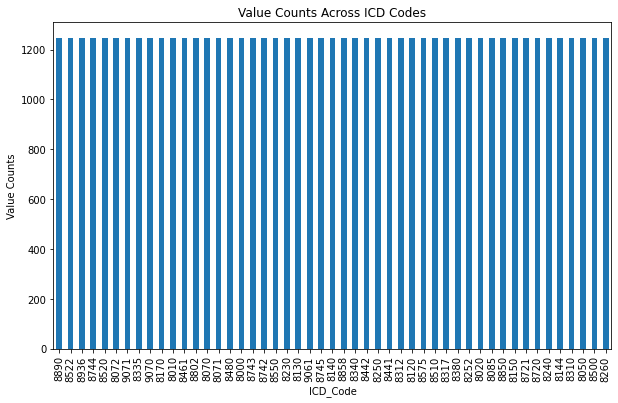

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
df_upsampled['Code'].value_counts().plot(ax=ax, kind='bar')
ax.set_xlabel("ICD_Code")
ax.set_ylabel("Value Counts")
ax.set_title("Value Counts Across ICD Codes");

In [ ]:
'''
#Load the pretrained bert model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
'''

"\n#Load the pretrained bert model\nmodel_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')\n\n# Load pretrained model/tokenizer\ntokenizer = tokenizer_class.from_pretrained(pretrained_weights)\nmodel = model_class.from_pretrained(pretrained_weights)\n"

In [ ]:
#df_upsampled.iloc[1392]

In [ ]:
tokenized = df_upsampled["Dx"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
tokenized.iloc[1392]

[101, 13866, 13656, 2062, 2084, 4642, 1999, 4602, 9812, 102]

In [ ]:
#pad everything to the same size! Set to the length of the largest input
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
#implement the attention mask
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(61103, 34)

In [ ]:
input_ids = torch.tensor(padded)

In [ ]:
#input_ids is the embedding of the sentence
print(len(input_ids))
print(len(df_upsampled))

61103
61103


In [ ]:
index = 1
print(input_ids[index])
print(df_upsampled["Dx"][index])

tensor([  101, 17503,  2482, 21081,  2863,  1997,  2053,  2569,  2828, 23245,
         2389,  2025,  4728,  9675,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
1    endometrioid carcinoma nos
1    endometrioid carcinoma nos
1    endometrioid carcinoma nos
1    endometrioid carcinoma nos
1    endometrioid carcinoma nos
1    endometrioid carcinoma nos
1    endometrioid carcinoma nos
1    endometrioid carcinoma nos
Name: Dx, dtype: object


In [ ]:
### Have to encode 0-9 each of the ICD Codes: 

In [ ]:
#vectorize the Y keys to corresponding values:
y_train = df_upsampled["Code"].values
y_train = np.vectorize(icd_codes_d.get)(y_train)
y_train

array([18, 18, 18, ..., 41, 41, 41])

In [ ]:
# train, dev, test: 

In [ ]:
# train-test split:
test_size = int(np.floor(len(y_train)*.25))
rand_test_ints = np.random.randint(low=0, high=len(y_train), size=test_size)

y_dev = y_train[rand_test_ints]
y_train = np.delete(y_train, rand_test_ints, axis=0)

x_dev = input_ids[rand_test_ints]
x_train = np.delete(input_ids, rand_test_ints, axis=0)

In [ ]:
y_train.shape, y_dev.shape

((47503,), (15275,))

In [ ]:
#Format X, Y for input into NN: (For Dataloader)
train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i]])
    
dev_data = []
for i in range(len(x_dev)):
    dev_data.append([x_dev[i], y_dev[i]])

In [ ]:
x_dev.shape

torch.Size([15275, 34])

# Classifying

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn

In [ ]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()

        input_dim = 120
        hidden_1 = 50
        hidden_2 = 10
        
        self.fc1 = nn.Linear(input_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 120)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
n_epochs = 100
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1000, num_workers=1)
devloader - torch.utils.data.DataLoader(dev_data, batch_size=1000, num_workers=1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1000, num_workers=1)
mlp = MLP()
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(mlp.parameters(), lr=.0001)
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001)

test_loss_min = 10000

for epoch in range(n_epochs):
    train_loss = 0
    test_loss = 0
    
    mlp.train()
    for data, target in trainloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        output = mlp(data.float())

        # Compute loss
        loss = criterion(output, target)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        train_loss += loss.item()*data.size(0)
        
    with torch.no_grad():
        for data, target in testloader:
            output = mlp(data.float())
            loss = criterion(output, target)
            test_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader.dataset)
    test_loss = test_loss/len(testloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    if test_loss <= test_loss_min:
        torch.save(mlp.state_dict(), 'mlp.pt')
        test_loss_min = test_loss

  # Process is complete.
print('All done.')

NameError: ignored

In [ ]:
# Load in the best model from the given run:
mlp.load_state_dict(torch.load('mlp.pt'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1)

In [ ]:
predictions = predict(mlp, testloader)
predictions = np.array(predictions)

In [ ]:
# Only predicting 3/8 not actually learning:
np.unique(predictions)

In [ ]:
print("Test Accuracy:", accuracy(y_test, predictions))

In [ ]:
class BLSTM(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=34, hidden_size=256,
                          num_layers=1, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.33)
        self.linear1 = nn.Linear(512, 128)
        self.elu = nn.ELU()
        self.linear2 = nn.Linear(128, 49)
        
        
    def forward(self, inputs):
        lstm_out, self.hidden = self.lstm(inputs.view(len(inputs), 1, -1))
        lstm_out_dropped = self.dropout(lstm_out)
        out = self.linear1(lstm_out_dropped.view(len(inputs), -1))
        elu_out = self.elu(out)
        l2_out = self.linear2(elu_out)
        log_probs = F.log_softmax(l2_out, dim=1)
        return log_probs

In [ ]:
len(train_data)

47965

In [ ]:
len(dev_data), len(test_data)

(15386, 1302)

In [ ]:
n_epochs = 20
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=1)
devloader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=1)
blstm = BLSTM()
criterion = nn.CrossEntropyLoss(ignore_index=-1, size_average=True) #therefore no need for softmax
optimizer = torch.optim.SGD(blstm.parameters(), lr=0.001, momentum=0.7)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

test_loss_min = 10000

for epoch in range(n_epochs):
    #scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    train_loss = 0
    test_loss = 0
    
    blstm.train()
    for data, target in trainloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
#         print(data)
#         print(target)
        #print(torch.cat(data,dim=0).reshape(1,400,316))
        #print(torch.cat(data,dim=0).size(0)) I think the problem is here.
        #print(data)
        output = blstm(data.float())

        # Compute loss
        loss = criterion(output, target)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

                # Print statistics
        #train_loss += loss.item()*torch.cat(data,dim=0).size(0)
        train_loss += loss.item()*data.size(0)
        
    with torch.no_grad():
        for data, target in devloader:
            output = blstm(data.float())
            loss = criterion(output, target)
#             test_loss += loss.item()*torch.cat(data,dim=0).size(0)
            test_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(trainloader.dataset)
    test_loss = test_loss/len(devloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        test_loss
        ))
    
    if test_loss <= test_loss_min:
        torch.save(blstm.state_dict(), 'blstm.pt')
        test_loss_min = test_loss

  # Process is complete.
print('All done.')


Epoch-0 lr: 0.001
Epoch: 1 	Training Loss: 3.022613 	Test Loss: 2.530339
Epoch-1 lr: 0.001
Epoch: 2 	Training Loss: 1.667347 	Test Loss: 1.568070
Epoch-2 lr: 0.001
Epoch: 3 	Training Loss: 0.899470 	Test Loss: 1.022448
Epoch-3 lr: 0.001
Epoch: 4 	Training Loss: 0.592775 	Test Loss: 0.738213
Epoch-4 lr: 0.001
Epoch: 5 	Training Loss: 0.439846 	Test Loss: 0.532499
Epoch-5 lr: 0.001
Epoch: 6 	Training Loss: 0.340683 	Test Loss: 0.413878
Epoch-6 lr: 0.001
Epoch: 7 	Training Loss: 0.281867 	Test Loss: 0.340977
Epoch-7 lr: 0.001
Epoch: 8 	Training Loss: 0.239100 	Test Loss: 0.285000
Epoch-8 lr: 0.001
Epoch: 9 	Training Loss: 0.205671 	Test Loss: 0.238194
Epoch-9 lr: 0.001
Epoch: 10 	Training Loss: 0.181598 	Test Loss: 0.209398
Epoch-10 lr: 0.001
Epoch: 11 	Training Loss: 0.161365 	Test Loss: 0.184008
Epoch-11 lr: 0.001
Epoch: 12 	Training Loss: 0.145098 	Test Loss: 0.162535
Epoch-12 lr: 0.001
Epoch: 13 	Training Loss: 0.132024 	Test Loss: 0.146537
Epoch-13 lr: 0.001
Epoch: 14 	Training Loss:

In [ ]:
# Load in the best model from the given run:
blstm = BLSTM()
blstm.load_state_dict(torch.load('blstm_98_percent.pt'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1)

In [ ]:
# Calculate Accuracy from trained model:
def predict(model, dataloader):
    prediction_list = []
    with torch.no_grad():
        for data, target in dataloader:
            output = model(data.float())
            _, predicted = torch.max(output.data, 1) 
            prediction_list.append(predicted)
    return prediction_list

In [ ]:
def accuracy(y_true, y_pred):
    score = sum(y_true == y_pred)/len(y_pred)
    return score

In [ ]:
predictions = predict(blstm, testloader)
predictions = np.array(predictions)

In [ ]:
#See what it's actually predicting:
np.unique(predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [ ]:
print("Test Accuracy:", accuracy(y_test, predictions))

Test Accuracy: 0.989247311827957


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        57
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       0.94      1.00      0.97        16
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         1
          11       0.94      0.94      0.94        16
          12       1.00      1.00      1.00        11
          13       0.97      1.00      0.98        30
          14       0.75      1.00      0.86         6
          15       1.00      1.00      1.00         9
          16       1.00      1.00      1.00         6
          17       1.00    

In [ ]:
### Results on specific text:

In [ ]:
#Create output df for selected subset:
row_num = [2, 10, 47, 999, 1299]
row_results_df = test.iloc[row_num, :]

bert_lst = []
results_lst = []
for idx in row_num:
  bert_lst.append(test_data[idx])
  results_lst.append(predictions[idx])

row_results_df["bert"] = bert_lst
row_results_df["pred"] = results_lst

In [ ]:
#Decode output:
key_to_code_d = {v:k for k,v in icd_codes_d.items()}

In [ ]:
#Results:
print("Text:", row_results_df.iloc[0]["Dx"])
print("Code:", row_results_df.iloc[0]["Code"])

print("BERT Encoded:", row_results_df.iloc[0]["bert"][0])
print("Pred:", key_to_code_d[row_results_df.iloc[0]["pred"]])


Text: invasive carcinoma of no special type ductal not otherwise specified
Code: 8500
BERT Encoded: tensor([  101, 17503,  2482, 21081,  2863,  1997,  2053,  2569,  2828, 23245,
         2389,  2025,  4728,  9675,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Pred: 8500


In [ ]:
#Results:
print("Text:", row_results_df.iloc[1]["Dx"])
print("Code:", row_results_df.iloc[1]["Code"])

print("BERT Encoded:", row_results_df.iloc[1]["bert"][0])
print("Pred:", key_to_code_d[row_results_df.iloc[1]["pred"]])

Text: human papillomavirus hpvmediated positive squamous cell carcinoma oropharynx
Code: 8085
BERT Encoded: tensor([  101,  2529,  6643,  8197,  7174,  2863, 23350,  6522,  2615, 16969,
         3064,  3893,  5490,  6692, 27711,  3526,  2482, 21081,  2863, 20298,
        21890, 18143,  2595,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Pred: 8085


In [ ]:
#Results:
print("Text:", row_results_df.iloc[2]["Dx"])
print("Code:", row_results_df.iloc[2]["Code"])

print("BERT Encoded:", row_results_df.iloc[2]["bert"][0])
print("Pred:", key_to_code_d[row_results_df.iloc[2]["pred"]])

Text: squamous cell carcinoma conventional keratinizing
Code: 8071
BERT Encoded: tensor([  101,  5490,  6692, 27711,  3526,  2482, 21081,  2863,  7511, 17710,
         8609,  5498,  6774,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Pred: 8071


In [ ]:
#Results:
print("Text:", row_results_df.iloc[3]["Dx"])
print("Code:", row_results_df.iloc[3]["Code"])

print("BERT Encoded:", row_results_df.iloc[3]["bert"][0])
print("Pred:", key_to_code_d[row_results_df.iloc[3]["pred"]])

Text: clear cell carcinoma
Code: 8310
BERT Encoded: tensor([  101,  3154,  3526,  2482, 21081,  2863,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Pred: 8310


In [ ]:
#Results:
print("Text:", row_results_df.iloc[4]["Dx"])
print("Code:", row_results_df.iloc[4]["Code"])

print("BERT Encoded:", row_results_df.iloc[4]["bert"][0])
print("Pred:", key_to_code_d[row_results_df.iloc[4]["pred"]])

Text: pt tumor cm or less in greatest dimension
Code: 8000
BERT Encoded: tensor([  101, 13866, 13656,  4642,  2030,  2625,  1999,  4602,  9812,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Pred: 8000
